c:\Users\endresjn\Documents\MRzero\MRzero-Core\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Timing check failed. Error listing follows:
Event: 6 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 11 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 16 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 21 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 26 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 31 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 36 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 41 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 46 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 51 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 56 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 61 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 66 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 71 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 76 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 81 - [type: adc delay: 20.0 us dwell: 78125.0 ns]

Event: 86 - [type: adc delay:

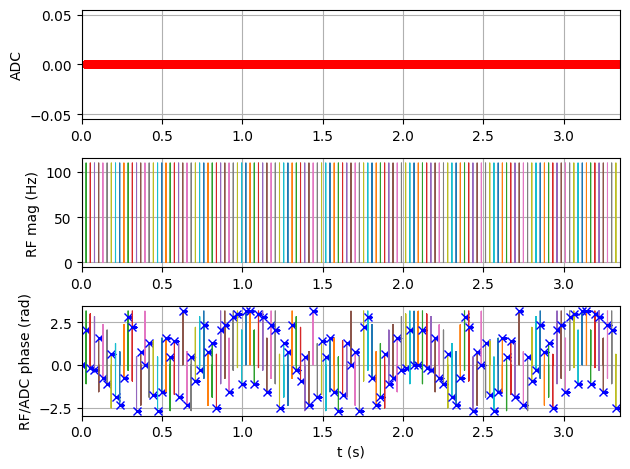

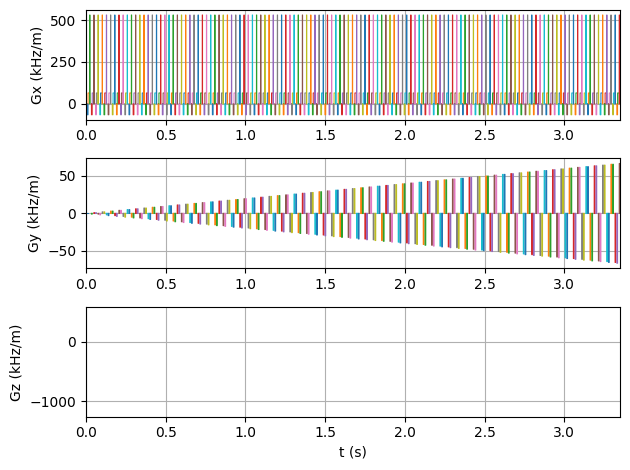

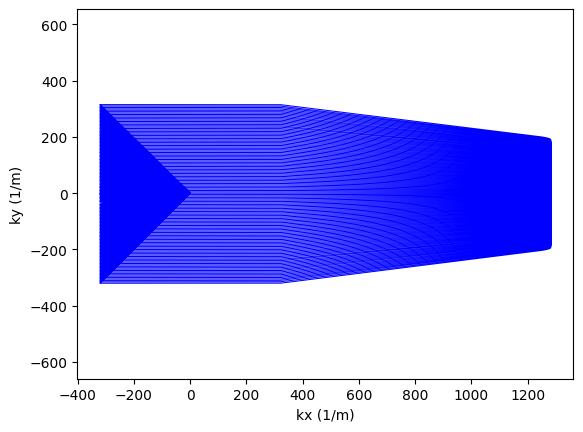

Voila, GPT4MR!


In [1]:
import numpy as np
import pypulseq as pp

# Setup scanner limits
system = pp.Opts(max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
                 rf_ringdown_time=20e-6, rf_dead_time=100e-6, adc_dead_time=20e-6,
                 grad_raster_time=10e-6)

seq = pp.Sequence()

# Define FOV and resolution
fov = 200e-3  # Field of View in meters
slice_thickness = 8e-3  # Slice thickness in meters
Nread = 128  # Frequency encoding steps
Nphase = 128  # Phase encoding steps

# Define RF excitation pulse
rf1, gz, gzr = pp.make_sinc_pulse(
    flip_angle=10 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

# Define gradients and ADC
dwell_time = 10e-3 / Nread
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=Nread * dwell_time, system=system)
adc = pp.make_adc(num_samples=Nread, duration=Nread * dwell_time, phase_offset=0, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=5e-3, system=system)
gx_spoil = pp.make_trapezoid(channel='x', area=1.5 * gx.area, duration=2e-3, system=system)

# Define RF spoiling
rf_phase = 0
rf_inc = 0
rf_spoiling_inc = 117

# Define phase encoding reordering
phenc = np.linspace(-Nphase // 2, Nphase // 2 - 1, Nphase) / fov
permvec = sorted(range(len(phenc)), key=lambda x: abs(len(phenc) // 2 - x))
phenc_centr = phenc[permvec]

# Add slice-selective RF pulse and gradient
seq.add_block(rf1, gz)
seq.add_block(gzr)

# Loop through phase encoding steps
for ii in range(Nphase):
    rf1.phase_offset = rf_phase * np.pi / 180  # Update RF phase
    adc.phase_offset = rf_phase * np.pi / 180  # Update ADC phase
    rf_inc = (rf_inc + rf_spoiling_inc) % 360  # Increment RF spoiling
    rf_phase = (rf_phase + rf_inc) % 360

    gp = pp.make_trapezoid(channel='y', area=phenc_centr[ii], duration=5e-3, system=system)
    seq.add_block(rf1)
    seq.add_block(pp.make_delay(5e-3))
    seq.add_block(gx_pre, gp)
    seq.add_block(adc, gx)
    gp_spoil = pp.make_trapezoid(channel='y', area=-phenc_centr[ii], duration=5e-3, system=system)
    seq.add_block(gx_spoil, gp_spoil)

# Timing check
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# Set definitions and save sequence
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'FLASH_128x128')
seq.write('FLASH_128x128.seq')

# Plot sequence
seq.plot()

# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()
import matplotlib.pyplot as plt
plt.plot(k_traj[0, :], k_traj[1, :], 'b-')
plt.xlabel('kx (1/m)'); plt.ylabel('ky (1/m)')
plt.axis('equal')
plt.show()

print('Voila, GPT4MR!')